# CMPUT 466/566, Winter 2020 Introduction to Machine learning 
## Coding Assignment 2 
### Problem 1 Report
By Nathan Klapstein #1449872

In [63]:

import struct

import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy.sparse


Load in the MNIST data for later compute.

In [64]:

def readMNISTdata():
    with open('data/t10k-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_data = test_data.reshape((size, nrows * ncols))

    with open('data/t10k-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_labels = test_labels.reshape((size, 1))

    with open('data/train-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_data = train_data.reshape((size, nrows * ncols))

    with open('data/train-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_labels = train_labels.reshape((size, 1))

    # augmenting a constant feature of 1 (absorbing the bias term)
    train_data = np.concatenate(
        (np.ones([train_data.shape[0], 1]), train_data), axis=1)
    test_data = np.concatenate((np.ones([test_data.shape[0], 1]), test_data),
                               axis=1)
    np.random.seed(314)
    np.random.shuffle(train_labels)
    np.random.seed(314)
    np.random.shuffle(train_data)

    X_train = train_data[:50000] / 256
    t_train = train_labels[:50000]

    X_val = train_data[50000:] / 256
    t_val = train_labels[50000:]

    return X_train, t_train, X_val, t_val, test_data, test_labels


X_train, t_train, X_val, t_val, X_test, t_test = readMNISTdata()


Various global configurations.

In [65]:
N_class = 10
alpha = 0.4  # learning rate
batch_size = 1000000  # batch size
MaxIter = 35  # Maximum iteration
decay = 0.  # weight decay

# TODO: figure this shit out
lam = 0.4

In [116]:

def oneHotIt(Y):
    """Convert unidimensional array of labels into a one-hot variant
    where the array is size m (examples) x n (classes)."""
    m = Y.shape[0]
    Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX


def softmax(z):
    z -= np.max(z) + np.min(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm


def getLoss(w,x,y,lam):
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T, (y_mat - prob)) + lam*w #And compute the gradient for that loss
    return loss, grad


def getProbsAndPreds(someX, w):
    probs = softmax(np.dot(someX, w))
    preds = np.argmax(probs,axis=1)
    return probs,preds


# inspired by https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16
# https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
def getAccuracy(someX,someY,w):
    prob, prede = getProbsAndPreds(someX,w)
    someY = someY.flatten()
    num_correct = np.sum(prede == someY)
    num_incorrect = np.sum(prede != someY)
    accuracy = num_correct/(num_correct+num_incorrect)
    return accuracy


def predict(X, W, t=None):
    # X_new: Nsample x (d+1)
    # W: (d+1) x K
    
    reg = 0.001
    # TODO Your code here
    y = np.matmul(X, W)
    
    # y = np.argmax(X.dot(W), 1)
    t_hat = np.argmax(y, axis=1)
    num_of_samples = X.shape[0]

    z = np.dot(X, W)
    z -= np.max(z, axis=0)  # Max trick for the softmax, preventing infinite values
    y_prob = np.exp(z) / np.sum(np.exp(z)) 
    # ~z_i = z_i - z_max_i
    # exp_z = np.exp(z - np.max(z, axis=0) + np.min(z, axis=0))
    # p = exp_z / np.sum(exp_z, axis=0) # softmax 
    # p = softmaxEquation(z)
     
    # compute the loss
    loss = -np.log(np.max(y_prob)) * t
    reg_loss = 0.5  * reg * np.sum(np.multiply(W, W))  # Regularization term
    cross_entropy_loss =  (1 / num_of_samples) * (np.sum(loss)) 
    total_loss = cross_entropy_loss + reg_loss
    # total_loss = cross_entropy_loss
    
    # compute the mean-per class accuracy
    acc = getAccuracy(X, t, W)
    
    # Calculation of dW (gradient)
    grad = ((-1 / num_of_samples) * np.dot(X.T, (t - y_prob))) + (reg * W)
    
    return y, t_hat, total_loss, acc, grad


def train(X_train, t_train, X_val, t_val):
    N_train = X_train.shape[0]
    N_val = X_val.shape[0]

    # TODO Your code here
    
    # initialization
    w = np.zeros([X_train.shape[1], N_class])
    # w: (d+1)x1

    losses_train = []
    acc_val = []
    w_best = None
    acc_best = 0
    epoch_best = 0
    
    for epoch in range(MaxIter):
        loss_this_epoch = 0
        for b in range(int(np.ceil(N_train / batch_size))):
            X_batch = X_train[b * batch_size: (b + 1) * batch_size]
            t_batch = t_train[b * batch_size: (b + 1) * batch_size]
            loss_batch, grad = getLoss(w, X_batch, t_batch, lam)
            loss_this_epoch += loss_batch
            w = w - (alpha * grad)
   
        # TODO: Your code here
        # monitor model behavior after each epoch
        
        # 1. Compute the training loss by averaging loss_this_epoch
        #         losses_train.append(loss_this_epoch/int(np.ceil(N_train/batch_size)))
        
    
        loss_this_epoch = loss_this_epoch / (int(np.ceil(batch_size)))
        val_acc = getAccuracy(X_val, t_val, w)
        print(f"epoch {epoch:>3}/{MaxIter:<2} loss:{loss_this_epoch:.18f} val_acc:{val_acc:.6f}")
        
        # test_acc = getAccuracy(X_train, t_train, w)
        # print(f"est_acc:{test_acc} val_acc:{val_acc}")
        losses_train.append(loss_this_epoch)
        #print(f"epoch={epoch} training loss={loss_this_epoch/  (int(np.ceil(N_train/batch_size)))}")

        # 2. Perform validation on the validation test by the risk
        # risk_this_epoch = 0
        # for c in range(int(np.ceil(N_val / batch_size))):
        #     X_val_batch = X_val[c * batch_size: (c + 1) * batch_size]
        #     y_val_batch = y_val[c * batch_size: (c + 1) * batch_size]
        #     _, _, risk = predict(X_val_batch, w, y_val_batch)
        #     risk_this_epoch += risk
        # TODO: FIXED: Validation set should not be run in batches
        # y, t_hat, _, acc, grad = predict(X_val, w, t_val)
        acc_val.append(val_acc)
        
        # 3. Keep track of the best validation epoch, risk, and the weights
        if acc_val[epoch] >= acc_best:
            epoch_best = epoch
            acc_best = acc_val[epoch]
            w_best = w

    # Return some variables as needed
    return epoch_best, losses_train, acc_val, acc_best, w_best


In [117]:
print(X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape,
      t_test.shape)


epoch_best, losses_train, acc_val, acc_best, W_best = train(X_train, t_train, X_val, t_val)


print(f"At epoch: {epoch_best} acc:{acc_best}")
print(f"The accuracy best epoch with val set is {acc_best:10.10f}")

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
epoch   0/35 loss:0.000002302585092994 val_acc:0.665000
epoch   1/35 loss:0.000001951664044804 val_acc:0.771900
epoch   2/35 loss:0.000001779179502292 val_acc:0.771400
epoch   3/35 loss:0.000001695926021289 val_acc:0.792800
epoch   4/35 loss:0.000001655109847758 val_acc:0.794700
epoch   5/35 loss:0.000001634609043410 val_acc:0.802600
epoch   6/35 loss:0.000001624113141116 val_acc:0.805100
epoch   7/35 loss:0.000001618603251585 val_acc:0.808700
epoch   8/35 loss:0.000001615654251455 val_acc:0.810400
epoch   9/35 loss:0.000001614039091420 val_acc:0.812500
epoch  10/35 loss:0.000001613137331665 val_acc:0.813500
epoch  11/35 loss:0.000001612623053750 val_acc:0.814500
epoch  12/35 loss:0.000001612324482305 val_acc:0.815700
epoch  13/35 loss:0.000001612147854759 val_acc:0.816100
epoch  14/35 loss:0.000001612041766496 val_acc:0.816800
epoch  15/35 loss:0.000001611977047679 val_acc:0.817400
epoch  16/35 loss:0.000001611937

The learning curve of the training loss, where x-axis is the number of epochs,
and y-axis is the training loss.

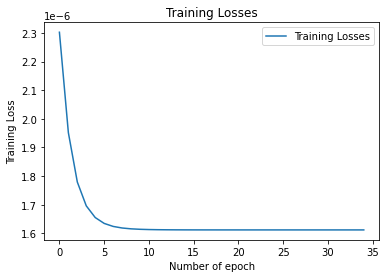

In [118]:

fig = plt.figure()
plt.plot(losses_train, label="Training Losses")
plt.title("Training Losses")
plt.legend()
plt.xlabel('Number of epoch')
plt.ylabel('Training Loss')
plt.show()


The accuracy curve, where x-axis is the number of epochs, and y-axis is the 
accuracy in decimal form (0.0-1.0).

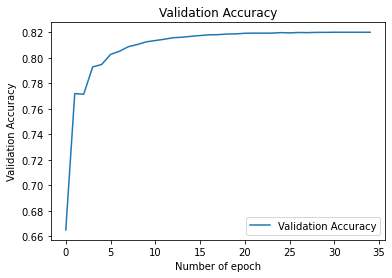

In [119]:

fig = plt.figure()
plt.plot(acc_val, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.xlabel('Number of epoch')
plt.ylabel('Validation Accuracy')
plt.show()

Doing predictions on the test set.

In [120]:
_, _, _, acc_best, _ = predict(X_test, W_best, t_test)

print(f"At epoch: {epoch_best} acc:{acc_best}")


At epoch: 34 acc:0.83


c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Various accuracies of the trained model.

In [121]:

print(f"train accuracy:{getAccuracy(X_train, t_train, W_best)}")
print(f"validation accuracy:{getAccuracy(X_val, t_val, W_best)}")
print(f"test accuracy:{getAccuracy(X_test, t_test, W_best)}")

train accuracy:0.82014
validation accuracy:0.82
test accuracy:0.83


c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
